In [1]:
!pip install split-folders

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import os
import zipfile

import cv2
import numpy as np

from matplotlib import pyplot as plt
import matplotlib.cm as cm

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

import pickle
from tqdm.notebook import tqdm

import splitfolders
from tensorflow.keras.applications.resnet import ResNet50
import datetime


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
base_path = '/content/drive/MyDrive/image_recognition/data/image_data/img/'

In [5]:
with zipfile.ZipFile(base_path + 'conjunctivitis.zip', 'r') as zip_ref:
  zip_ref.extractall('/content')

In [6]:
splitfolders.ratio('/content/conjunctivitis', output = 'conjunctivitis_dataset', seed = 77, ratio = (0.8, 0.1, 0.1))

Copying files: 19198 files [00:02, 6692.96 files/s]


## Zero-Centering

In [7]:
train_path = '/content/conjunctivitis_dataset/train'
img_paths = []
for label in os.listdir(train_path):
  sub_path = train_path + '/' + label + '/'
  for files in os.listdir(sub_path):
    img_paths.append(sub_path + files)


In [8]:
X_train = []

for img_file in img_paths:
  img = cv2.imread(img_file)
  X_train.append(img)

In [9]:
compute_mean = lambda imgs: np.mean(imgs, axis = 0)
mean_img = compute_mean(X_train)
sub_mean_img = lambda image: image - mean_img

In [10]:
batch_size = 128

In [11]:
train_datagen = ImageDataGenerator(preprocessing_function=sub_mean_img)
val_datagen = ImageDataGenerator(preprocessing_function=sub_mean_img)
test_datagen = ImageDataGenerator(preprocessing_function=sub_mean_img)

In [12]:
train_generator = train_datagen.flow_from_directory('/content/conjunctivitis_dataset/train', batch_size=batch_size, target_size=(224, 224), class_mode = 'binary')
val_generator = val_datagen.flow_from_directory('/content/conjunctivitis_dataset/val', batch_size=batch_size, target_size=(224, 224), class_mode = 'binary')
test_generator = test_datagen.flow_from_directory('/content/conjunctivitis_dataset/test', batch_size=batch_size, target_size=(224, 224), class_mode = 'binary')

Found 15358 images belonging to 2 classes.
Found 1919 images belonging to 2 classes.
Found 1921 images belonging to 2 classes.


In [13]:
base_model_50 = ResNet50(include_top = False, input_shape = (224, 224, 3), weights = 'imagenet')

base_model_50.trainable = True

for layer in base_model_50.layers[:-10]:
  layer.trainable = False

inputs = tf.keras.Input(shape= (224, 224, 3))

x = base_model_50(inputs, training = False)
x = tf.keras.layers.Flatten(input_shape=base_model_50.output_shape[1:])(x)
x = tf.keras.layers.Dense(256, activation = 'relu')(x)
x = tf.keras.layers.Dropout(0.5)(x)
outputs = tf.keras.layers.Dense(1, activation = 'sigmoid')(x)
s_model_res50 = tf.keras.Model(inputs, outputs)


94765736/94765736 [==============================] - 6s 0us/step


In [14]:
s_model_res50.compile(optimizer='adam', loss= 'binary_crossentropy', metrics = ['accuracy', 'Recall'])

In [15]:
  history = s_model_res50.fit(train_generator, validation_data = val_generator, epochs = 10)

Epoch 1/10
120/120 [==============================] - 80s 526ms/step - loss: 0.7844 - accuracy: 0.9398 - recall: 0.9422 - val_loss: 0.4363 - val_accuracy: 0.8692 - val_recall: 0.7383
Epoch 2/10
120/120 [==============================] - 60s 495ms/step - loss: 0.0488 - accuracy: 0.9865 - recall: 0.9846 - val_loss: 0.0244 - val_accuracy: 0.9927 - val_recall: 0.9958
Epoch 3/10
120/120 [==============================] - 59s 493ms/step - loss: 0.0234 - accuracy: 0.9949 - recall: 0.9940 - val_loss: 0.0165 - val_accuracy: 0.9937 - val_recall: 0.9906
Epoch 4/10
120/120 [==============================] - 59s 492ms/step - loss: 0.0152 - accuracy: 0.9962 - recall: 0.9958 - val_loss: 0.0109 - val_accuracy: 0.9953 - val_recall: 0.9948
Epoch 5/10
120/120 [==============================] - 59s 493ms/step - loss: 0.0077 - accuracy: 0.9978 - recall: 0.9969 - val_loss: 0.0126 - val_accuracy: 0.9958 - val_recall: 0.9958
Epoch 6/10
120/120 [==============================] - 59s 493ms/step - loss: 0.0091 -

In [16]:
s_model_res50.evaluate(test_generator)

16/16 [==============================] - 7s 401ms/step - loss: 0.0254 - accuracy: 0.9891 - recall: 0.9792


[0.025381138548254967, 0.9890682101249695, 0.9791883230209351]

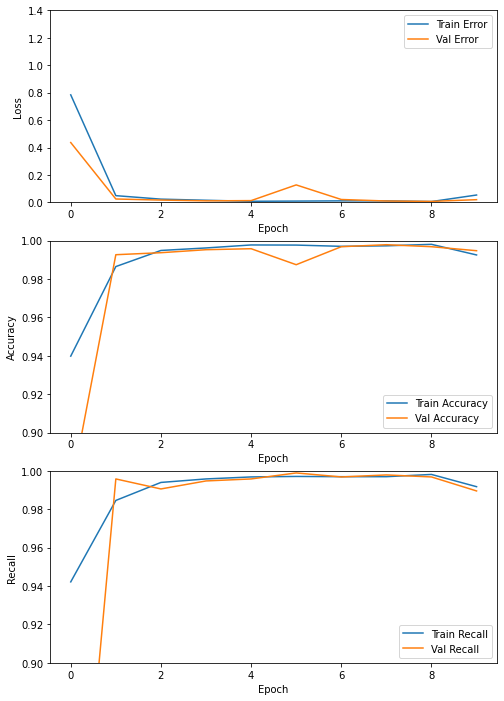

In [20]:
import matplotlib.pyplot as plt
import pandas as pd

def plot_history(history):
  hist = pd.DataFrame(history.history)
  hist['epoch'] = history.epoch

  plt.figure(figsize=(8,12))

  plt.subplot(3,1,1)
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.plot(hist['epoch'], hist['loss'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_loss'],
           label = 'Val Error')
  plt.ylim([0,1.4])
  plt.legend()
  
  plt.subplot(3,1,2)
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy')
  plt.plot(hist['epoch'], hist['accuracy'],
           label='Train Accuracy')
  plt.plot(hist['epoch'], hist['val_accuracy'],
           label = 'Val Accuracy')
  plt.ylim([0.9,1])
  plt.legend()

  plt.subplot(3,1,3)
  plt.xlabel('Epoch')
  plt.ylabel('Recall')
  plt.plot(hist['epoch'], hist['recall'],
           label='Train Recall')
  plt.plot(hist['epoch'], hist['val_recall'],
           label = 'Val Recall')
  plt.ylim([0.9,1])
  plt.legend()
  plt.show()

plot_history(history)